In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
X = pd.read_csv("/Users/lancesanterre/so_predict/data/training/new_training/X_train.csv")
y = pd.read_csv("/Users/lancesanterre/so_predict/data/training/new_training/y_5_train.csv")

In [3]:
y = y["0"] 
y.shape

(18958,)

In [4]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, mean_squared_error
from joblib import dump, load

# Set seed
np.random.seed(42)

# === Load Data ===
try:
    selected_features = load('selected_features.pkl')
    print(f"✅ Loaded {len(selected_features)} selected features: {selected_features[:10]}")

    X_full = pd.read_csv("/Users/lancesanterre/so_predict/data/training/new_training/X_train.csv")
    y = pd.read_csv("/Users/lancesanterre/so_predict/data/training/new_training/y_5_train.csv")
    y = y['0']
    print(len(X_full),len(y))
    assert len(X_full) == len(y)
    X = X_full[selected_features]
    print(f"✅ Data loaded successfully. Target mean: {np.mean(y):.4f}")
    print("🎯 Unique target values:", np.unique(y))

except Exception as e:
    print("❌ Error loading data:", str(e))
    raise

# === Determine Problem Type ===
target_classes = np.unique(y)
if len(target_classes) == 2:
    problem_type = "binary"
elif np.issubdtype(y.dtype, np.integer) and len(target_classes) <= 10:
    problem_type = "multiclass"
else:
    problem_type = "regression"
print(f"🔎 Detected problem type: {problem_type}")

# === Optional Binary Conversion Logic ===
# Uncomment below if you want to force binary classification manually
# y = (y >= 5).astype(int)
# problem_type = "binary"

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Hyperparameter Tuning ===
def tune_model(X, y, problem_type):
    print(f"\n🔧 Tuning Random Forest ({problem_type})...")
    start_time = time.time()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [20, 30, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    if problem_type == "regression":
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        scoring = 'r2'
    elif problem_type == "binary":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        scoring = 'roc_auc'
    else:
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        scoring = 'accuracy'

    grid = GridSearchCV(model, param_grid, cv=5, scoring=scoring, n_jobs=-1)
    grid.fit(X_scaled, y)

    print(f"✅ Best Parameters: {grid.best_params_}")
    print(f"📈 Best CV Score ({scoring}): {grid.best_score_:.4f}")
    print(f"⏱️ Tuning took {time.time() - start_time:.2f}s")
    return grid.best_estimator_, grid.best_params_, grid.best_score_, scaler

# === Train Final Model ===
def train_model(X, y, model, scaler, feature_names):
    print("\n🧠 Training final model...")
    X_scaled = scaler.transform(X)
    model.fit(X_scaled, y)

    if hasattr(model, "feature_importances_"):
        importances = pd.DataFrame({'Feature': feature_names, 'Importance': model.feature_importances_})
        importances = importances.sort_values('Importance', ascending=False)
        importances.to_csv('final_feature_importances.csv', index=False)
        print("📊 Saved feature importances to 'final_feature_importances.csv'")
        print("🏆 Top 5 features:\n", importances.head())
    else:
        importances = None

    dump(model, 'final_rf_model.pkl')
    dump(scaler, 'scaler.pkl')
    print("✅ Model saved as 'final_rf_model.pkl'")
    print("✅ Scaler saved as 'scaler.pkl'")
    return model, importances

# === Evaluate Model ===
def evaluate_model(X, y, model, scaler, problem_type):
    print("\n🧪 Evaluating on test set...")
    X_scaled = scaler.transform(X)

    if problem_type == "regression":
        preds = model.predict(X_scaled)
        r2 = r2_score(y, preds)
        mse = mean_squared_error(y, preds)
        print(f"📈 R² Score: {r2:.4f}, MSE: {mse:.4f}")
        return r2
    elif problem_type == "binary":
        proba = model.predict_proba(X_scaled)[:, 1]
        auc = roc_auc_score(y, proba)
        print(f"📈 ROC AUC: {auc:.4f}")
        return auc
    else:
        preds = model.predict(X_scaled)
        acc = accuracy_score(y, preds)
        print(f"📈 Accuracy: {acc:.4f}")
        return acc

# === Run All Steps ===
best_model, best_params, best_cv_score, scaler = tune_model(X_train, y_train, problem_type)
final_model, importances = train_model(X_train, y_train, best_model, scaler, selected_features)
test_score = evaluate_model(X_test, y_test, final_model, scaler, problem_type)

# === Final Summary ===
print("\n🎯 Final Results:")
print(f"🔧 Best Hyperparameters: {best_params}")
print(f"📊 Best CV Score: {best_cv_score:.4f}")
print(f"🧪 Test Set Score: {test_score:.4f}")


✅ Loaded 75 selected features: ['avg_SO_5', 'avg_IP_5', 'OPP_SO_PRE', 'avg_ERA_5', 'Gtm', 'avg_FB_5', 'avg_WPA_5', 'avg_GB_5', 'avg_aLI_5', 'avg_H_5']
18958 18958
✅ Data loaded successfully. Target mean: 0.4455
🎯 Unique target values: [0 1]
🔎 Detected problem type: binary

🔧 Tuning Random Forest (binary)...
✅ Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
📈 Best CV Score (roc_auc): 0.8158
⏱️ Tuning took 157.24s

🧠 Training final model...
📊 Saved feature importances to 'final_feature_importances.csv'
🏆 Top 5 features:
       Feature  Importance
0    avg_SO_5    0.075899
2  OPP_SO_PRE    0.039870
1    avg_IP_5    0.036537
3   avg_ERA_5    0.033288
4         Gtm    0.029870
✅ Model saved as 'final_rf_model.pkl'
✅ Scaler saved as 'scaler.pkl'

🧪 Evaluating on test set...
📈 ROC AUC: 0.8366

🎯 Final Results:
🔧 Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
📊 Best CV Score: 0.8

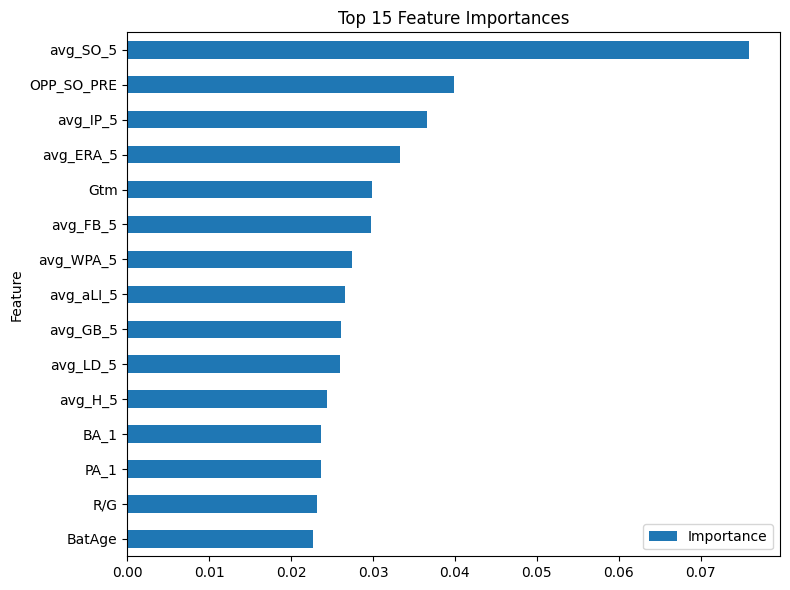

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("final_feature_importances.csv")
df.head(15).plot(kind="barh", x="Feature", y="Importance", title="Top 15 Feature Importances", figsize=(8,6))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_pred = final_model.predict(scaler.transform(X_test))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[1670  445]
 [ 523 1154]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      2115
           1       0.72      0.69      0.70      1677

    accuracy                           0.74      3792
   macro avg       0.74      0.74      0.74      3792
weighted avg       0.74      0.74      0.74      3792

